<p style="color:red">1 — Importation des bibliothèques</p>

In [11]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

<p style="color:red">2 — Définition du modèle flou (reprend celui du TP1)</p>

In [12]:
distance = ctrl.Antecedent(np.arange(0, 31, 1), 'Distance_to_next_car')
speed_change = ctrl.Antecedent(np.arange(-20, 21, 1), 'Speed_change')

In [13]:
acceleration = ctrl.Consequent(np.arange(-3, 3.1, 0.1), 'Acceleration_Adjust')

In [14]:
distance['v_small'] = fuzz.trapmf(distance.universe, [0, 0, 3, 6])
distance['small'] = fuzz.trimf(distance.universe, [4, 8, 12])
distance['perfect'] = fuzz.trimf(distance.universe, [10, 15, 20])
distance['big'] = fuzz.trimf(distance.universe, [18, 22, 26])
distance['v_big'] = fuzz.trapmf(distance.universe, [24, 27, 30, 30])

speed_change['declining'] = fuzz.trapmf(speed_change.universe, [-20, -20, -10, -2])
speed_change['constant'] = fuzz.trimf(speed_change.universe, [-3, 0, 3])
speed_change['growing'] = fuzz.trapmf(speed_change.universe, [2, 8, 20, 20])

acceleration['neg_big'] = fuzz.trapmf(acceleration.universe, [-3, -3, -2.5, -1.5])
acceleration['neg_small'] = fuzz.trimf(acceleration.universe, [-2, -1, 0])
acceleration['zero'] = fuzz.trimf(acceleration.universe, [-0.5, 0, 0.5])
acceleration['pos_small'] = fuzz.trimf(acceleration.universe, [0, 1, 2])
acceleration['pos_big'] = fuzz.trapmf(acceleration.universe, [1.5, 2.5, 3, 3])

<p style="color:red">3 — Définition des règles</p>

In [15]:
rule1 = ctrl.Rule(distance['v_small'] & speed_change['declining'], acceleration['neg_small'])
rule2 = ctrl.Rule(distance['v_small'] & speed_change['constant'], acceleration['neg_big'])
rule3 = ctrl.Rule(distance['v_small'] & speed_change['growing'], acceleration['neg_big'])
rule4 = ctrl.Rule(distance['small'] & speed_change['declining'], acceleration['zero'])
rule5 = ctrl.Rule(distance['small'] & speed_change['constant'], acceleration['neg_small'])
rule6 = ctrl.Rule(distance['small'] & speed_change['growing'], acceleration['neg_big'])
rule7 = ctrl.Rule(distance['perfect'] & speed_change['declining'], acceleration['pos_small'])
rule8 = ctrl.Rule(distance['perfect'] & speed_change['constant'], acceleration['zero'])
rule9 = ctrl.Rule(distance['perfect'] & speed_change['growing'], acceleration['neg_small'])
rule10 = ctrl.Rule(distance['big'] & speed_change['declining'], acceleration['pos_big'])
rule11 = ctrl.Rule(distance['big'] & speed_change['constant'], acceleration['pos_small'])
rule12 = ctrl.Rule(distance['big'] & speed_change['growing'], acceleration['zero'])
rule13 = ctrl.Rule(distance['v_big'] & speed_change['declining'], acceleration['pos_big'])
rule14 = ctrl.Rule(distance['v_big'] & speed_change['constant'], acceleration['pos_big'])
rule15 = ctrl.Rule(distance['v_big'] & speed_change['growing'], acceleration['pos_small'])


In [16]:
accel_ctrl = ctrl.ControlSystem([
    rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8,
    rule9, rule10, rule11, rule12, rule13, rule14, rule15
])
accel_sim = ctrl.ControlSystemSimulation(accel_ctrl)

<p style="color:red">4 — Génération du dataset synthétique</p>

In [17]:
n = 1000
distances = np.random.uniform(0, 30, n)
speeds = np.random.uniform(-20, 20, n)
outputs = []

for d, s in zip(distances, speeds):
    accel_sim.input['Distance_to_next_car'] = d
    accel_sim.input['Speed_change'] = s
    accel_sim.compute()
    outputs.append(accel_sim.output['Acceleration_Adjust'])

# Dataset final
df = pd.DataFrame({
    'Distance_to_next_car': distances,
    'Speed_change': speeds,
    'Acceleration_Adjust': outputs
})
df.head()

,Distance_to_next_car,Speed_change,Acceleration_Adjust
0,19.071693,0.585881,0.787924
1,20.869958,-16.056010,2.392224
2,18.384882,17.434223,-0.896416
3,17.005930,-13.120941,1.000000
4,29.767524,19.188872,1.000000


<p style="color:red">5 — Entraînement d’un modèle ML</p>

In [18]:
X = df[['Distance_to_next_car', 'Speed_change']]
y = df['Acceleration_Adjust']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle de régression (Random Forest)
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
y_pred = model.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"MAE = {mae:.4f}")
print(f"MSE = {mse:.4f}")

MAE = 0.0208
MSE = 0.0022


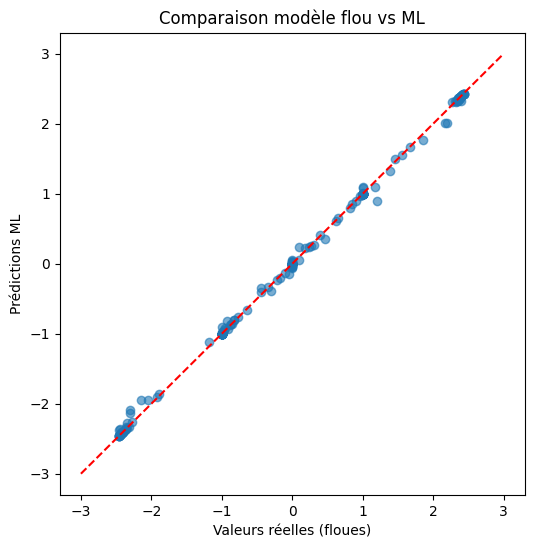

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Valeurs réelles (floues)")
plt.ylabel("Prédictions ML")
plt.title("Comparaison modèle flou vs ML")
plt.plot([-3, 3], [-3, 3], 'r--')
plt.show()

<p style="color:red">6 — Comparaison Logique Floue vs Machine Learning</p>

In [21]:
print("\n🧠 Comparaison :")
print("- Logique floue :")
print("  • Avantage → Explicabilité, basée sur des règles linguistiques simples")
print("  • Inconvénient → Moins précise, nécessite réglage manuel des fonctions")
print("- Machine Learning :")
print("  • Avantage → Haute précision après entraînement sur données")
print("  • Inconvénient → Boîte noire, difficile à interpréter sans SHAP ou LIME")


🧠 Comparaison :
- Logique floue :
  • Avantage → Explicabilité, basée sur des règles linguistiques simples
  • Inconvénient → Moins précise, nécessite réglage manuel des fonctions
- Machine Learning :
  • Avantage → Haute précision après entraînement sur données
  • Inconvénient → Boîte noire, difficile à interpréter sans SHAP ou LIME
